In [2]:
import os
import logging
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import json

logger = logging.getLogger(__name__)

### Data processing 

In [3]:
# read data from jsonl file as a pandas dataframe 
import pandas as pd
import json
file_path = '/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/dataset/test.jsonl'

examples = [] 
labels = []
with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                examples.append(' '.join(js['func'].split()))
                labels.append(js['target'])

In [4]:
len(examples), len(labels)

(2732, 2732)

In [5]:
## Before tokenization 
defect_func = [examples[i] for i in range(len(examples)) if labels[i] == 1]
non_defect_func = [examples[i] for i in range(len(examples)) if labels[i] == 0]

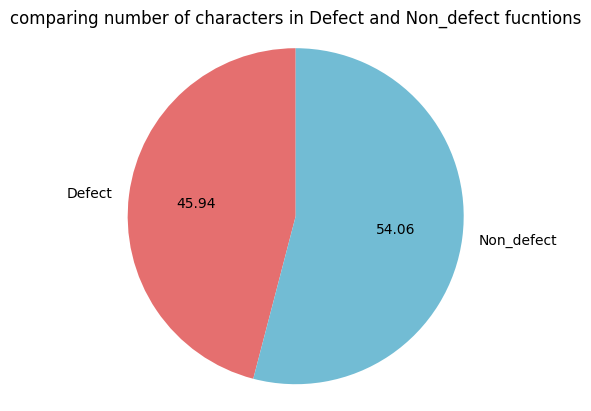

In [6]:
from matplotlib import pyplot as plt

tot_chars = []
tot_chars.append(len(defect_func))
tot_chars.append(len(non_defect_func))
labels_ = 'Defect','Non_defect'
colors = ['#e56f6f', "#72bcd4"]
ax1=plt.pie(tot_chars, colors=colors, shadow=False, startangle=90, labels=labels_, autopct='%.2f')
plt.axis('equal')
plt.title("comparing number of characters in Defect and Non_defect fucntions")
plt.show()

#### Function length historgram charts 

In [7]:
defect_func_len = [len(examples[i].split(" ")) for i in range(len(examples)) if labels[i] == 1]
non_defect_func_len = [len(examples[i].split(" ")) for i in range(len(examples)) if labels[i] == 0]

In [8]:
print("The maxmum and minimum Len for defect func:", max(defect_func_len), min(defect_func_len))

print("The maxmum and minimum Len for non defect func:", max(non_defect_func_len), min(non_defect_func_len))

The maxmum and minimum Len for defect func: 12195 4
The maxmum and minimum Len for defect func: 7755 4


Text(0.5, 1.0, 'comparing number of tokens per function distribution in Defect and non_defect functions')

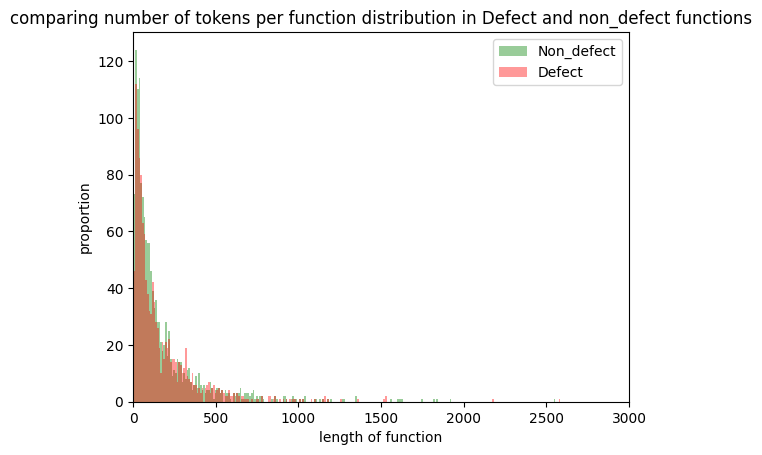

In [34]:
maxBin = 3000
plt.hist(non_defect_func_len, range=[0,maxBin],
         bins=range(min(non_defect_func_len), max(non_defect_func_len) + 1, 10), 
              alpha=0.4, color="green")
plt.hist(defect_func_len, range=[0,maxBin], 
         bins=range(min(defect_func_len), max(defect_func_len) + 1, 10), 
              alpha=0.4, color="red")

labels_ = ["Non_defect", 'Defect']
plt.legend(labels_)
plt.xlabel("length of function")
plt.xlim(0, maxBin)
plt.ylabel("proportion")
plt.title("comparing number of tokens per function distribution in Defect and non_defect functions")

In [11]:
import torch
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

In [12]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label

In [13]:
def convert_examples_to_features(js, tokenizer, block_size=512):
    #source
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

In [14]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path=None, block_size=512):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features(js,tokenizer, block_size))
                
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                    logger.info("*** Example ***")
                    logger.info("idx: {}".format(idx))
                    logger.info("label: {}".format(example.label))
                    logger.info("input_tokens: {}".format([x.replace('\u0120','_') for x in example.input_tokens]))
                    logger.info("input_ids: {}".format(' '.join(map(str, example.input_ids))))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)
    

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name_or_path = "microsoft/codebert-base"

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta'] 

config = config_class.from_pretrained(model_name_or_path, cache_dir=None)

config.num_labels=1
tokenizer = tokenizer_class.from_pretrained(model_name_or_path,
                                            do_lower_case=False,
                                            cache_dir=None)
block_size = 512

In [29]:
# print(config)

In [37]:
from model import Model

model = model_class(config)
model=Model(model,config,tokenizer,None)
# load checkpoints 
checkpoint_prefix = "./saved_models/checkpoint-best-acc/model.bin"
model.load_state_dict(torch.load(checkpoint_prefix)) 
model = model.to(device)

In [38]:
model

Model(
  (encoder): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_feat

In [17]:
eval_data_file = '/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/dataset/test.jsonl'
eval_dataset = TextDataset(tokenizer, eval_data_file, block_size=512)
eval_dataloader = DataLoader(eval_dataset, batch_size=128,num_workers=4,pin_memory=True)

In [26]:
# Eval!
eval_loss = 0.0
nb_eval_steps = 0

model.eval()
logits=[] 
labels=[]

for batch in eval_dataloader:
    inputs = batch[0].to(device)
    label=batch[1].to(device)
    # no need to compute gradient for evaluation
    with torch.no_grad():
        lm_loss,logit = model(inputs,label)
        eval_loss += lm_loss.mean().item()
        logits.append(logit.cpu().numpy())
        labels.append(label.cpu().numpy())
        
    nb_eval_steps += 1

logits=np.concatenate(logits,0)
labels=np.concatenate(labels,0)
# generate predictions
preds=logits[:,0]>0.5
# calculate accuracy
eval_acc=np.mean(labels==preds)
# calculate perplexity using cross entropy from loss
eval_loss = eval_loss/nb_eval_steps
perplexity = torch.tensor(eval_loss)
result = {
    "eval_loss": float(perplexity),
    "eval_acc":round(eval_acc,4),
}
print(result)